In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [3]:
base_csv = '/Volumes/Cisco/Fall2021/onnx-exchange/Training/IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


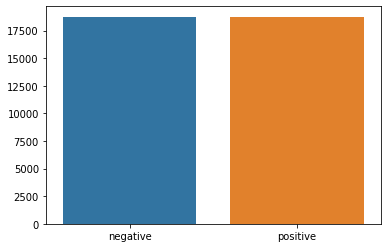

In [5]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [6]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s
import nltk
nltk.download('stopwords')
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mosesopenja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [8]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


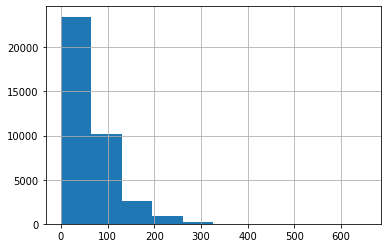

count    37500.00000
mean        69.07032
std         48.00714
min          0.00000
25%         39.00000
50%         54.00000
75%         84.00000
max        652.00000
dtype: float64

In [9]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [10]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [11]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [12]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 128

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [13]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([128, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,   5,  30, 288],
        [  0,   0,   0,  ...,  45,   1, 440],
        [  0,   0,   0,  ...,  26, 132,   5],
        ...,
        [  0,   0,   0,  ...,  21, 328,   9],
        [  0,   0,   0,  ...,   7, 291, 862],
        [  0,   0,   0,  ..., 762,   1,   1]])
Sample input: 
 tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0])


In [14]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256

In [15]:
training_round = 10
training_id = training_round
model_short_name = 'gru'
framework = 'pytorch'

In [16]:
import time
import os
import copy
import csv
import pandas as pd
from datetime import datetime

date = datetime.today().strftime('%Y-%m-%d')

In [17]:
class GRURNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5, batch_size=100):
        #super(SentimentRNN,self).__init__()
        super().__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.gru = nn.GRU(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        gru_out, hidden = self.gru(embeds, hidden)
        
        gru_out = gru_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(gru_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.no_layers,batch_size,self.hidden_dim).zero_().to(device)
        return hidden

In [18]:
model = GRURNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5, batch_size=128)

In [19]:
path = '/Volumes/Cisco/Summer2022/onnx-exchange/Train2/{}/{}/'.format(framework, model_short_name)
since_0 = time.time()
model_name = 'torch_state_GRU-IMDb_2022-03-11_{}'.format(training_id)
model.load_state_dict(torch.load(path+model_name+'.pb', map_location=torch.device('cpu')))
t_elapsed_0 = time.time() - since_0

size0 = os.path.getsize(path+model_name+'.pb')
size0

#moving to gpu
model.to(device)

print(model)

GRURNN(
  (embedding): Embedding(1001, 64)
  (gru): GRU(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [20]:
import onnx
import onnxruntime
import coremltools
import time

from six import string_types as _string_types
from coremltools import TensorType
#from coremltools.converters.mil.testing_reqs import _converter

Using TensorFlow backend.


In [21]:
onnx_path = '/Volumes/Cisco/Summer2022/onnx-exchange/Train2/conversion/onnx/'
coreml_path = '/Volumes/Cisco/Summer2022/onnx-exchange/Train2/conversion/coremltools/'
error_path = '/Volumes/Cisco/Fall2021/onnx-exchange/miss-classification/errors/'

In [22]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()
def trace_model(model, input_data):
    model.eval()
    if isinstance(input_data, list):
        input_data = tuple(input_data)
    torch_model = torch.jit.trace(model, input_data)
    return torch_model
def _flatten(object):
    flattened_list = []
    for item in object:
        if isinstance(item, (list, tuple)):
            flattened_list.extend(_flatten(item))
        else:
            flattened_list.append(item)
    return flattened_list
def flatten_and_detach_torch_results(torch_results):
    if isinstance(torch_results, (list, tuple)):
        #return [x.detach().numpy() for x in _flatten(torch_results)]
        return [x.cpu().numpy() for x in _flatten(torch_results)]
    # Do not need to flatten
    return [torch_results.detach().numpy()]
def convert_to_coreml_inputs(input_description, inputs):
    """Convenience function to combine a CoreML model's input description and
    set of raw inputs into the format expected by the model's predict function.
    """
    flattened_inputs = _flatten(inputs)
    coreml_inputs = {
        str(x): to_numpy(inp).astype(np.float64) for x, inp in zip(input_description, flattened_inputs)
    }
    #str(x): to_numpy(inp).numpy() for x, inp in zip(input_description, flattened_inputs)
    return coreml_inputs
from coremltools.converters.mil.mil import types
def _convert_to_inputtype(inputs): 
    if isinstance(inputs, list): 
        return [_convert_to_inputtype(x) for x in inputs]
    elif isinstance(inputs, tuple):
        return tuple([_convert_to_inputtype(x) for x in inputs])
        #return tuple([coremltools.TensorType(shape=x.shape) for x in inputs])
    elif isinstance(inputs, torch.Tensor):
        return coremltools.TensorType(shape=inputs.shape, dtype=types.int64)
    else:
        raise ValueError("Unable to parse type {} into InputType.".format(type(inputs)))
        
def model_scores(y_test, test_predict):
    correct_ = np.sum(y_test == test_predict)
    accuracy  = correct_*100./np.sum(y_test == y_test)
    return accuracy


In [23]:
def to_onnx(i, x, y, data_writer_run, batch_size):
    
    # Input to the model
    #device_reset = cuda.get_current_device()
    #device_reset.reset()
    #x.cuda()
    print("converting for batch: ", i)
    y = to_numpy(y.squeeze())
    #torch.random.manual_seed(42)
    #x = torch.randn(10000, 3, 32, 32, requires_grad=True)
    
    ### Original Model
    torch.random.manual_seed(42)
    #x = torch.randn(10000, 3, 32, 32, requires_grad=True)
    
    #model = torch.load(path+model_name+'.pth')
    val_h = model.init_hidden(batch_size)
    val_h = val_h.data
    #inputs, labels = x.to(device), labels.to(device)

    output, val_h = model(x, val_h)
    weight = next(model.parameters()).data
    hidden = weight.new(no_layers,batch_size,hidden_dim).zero_().to(device)
    h0 = torch.randn(no_layers,batch_size,hidden_dim) #.cuda()
    
    input_x = (x, hidden)
    traced_model = trace_model(model, input_x)
    if isinstance(traced_model, _string_types):
        torch_model = torch.jit.load(traced_model)
    else:
        torch_model = traced_model
    if not isinstance(input_x, (list, tuple)):
        input_x = [input_x]
    
    since_1 = time.time()
    torch_out, (hn, cn) = model(x, hidden)
    inference_time_original = time.time() - since_1
    y0 = to_numpy(torch.round(torch_out.squeeze()))
    accuracy_original = model_scores(y, y0)
    
    
    # ONNX Model
    
    since_1 = time.time()
    
    
    #input_names = ["input", "h0", "c0"]
    #output_names = ["output", "hn", "cn"]

    #torch.onnx.export(model, (x, (h0, c0)), 
    #              onnx_path+framework+"/{}/{}-v2.onnx".format(model_short_name, model_name),
    #                  input_names=input_names, output_names=output_names)
    #t_onnx_conversion = time.time() - since_1
    
    
    since_1 = time.time()
    onnx_model = onnx.load(onnx_path+framework+"/{}/{}.onnx".format(model_short_name, model_name))
    load_time_onnx = time.time() - since_1
    onnx.checker.check_model(onnx_model)
    size_onnx = os.path.getsize(onnx_path+framework+"/{}/{}.onnx".format(model_short_name, model_name))
    #def to_numpy(tensor):
    #    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()
    ort_session = onnxruntime.InferenceSession(onnx_path+framework+"/{}/{}.onnx".format(model_short_name, model_name))
    since_1 = time.time()
    ort_outs = ort_session.run(None, {ort_session.get_inputs()[0].name: to_numpy(x), 'hidden':to_numpy(hidden)})
    inference_time_onnx = time.time() - since_1
    # compare ONNX Runtime and PyTorch results
    print("\n*********\n\n")
    #time_diff = t_elapsed_0+t_elapsed_1, t_elapsed_2, t_elapsed_3
    
    ####### Mis-classification ONNX ######################################
    ort_outs_tensor = torch.from_numpy(ort_outs[0]) 
    y2 = to_numpy(torch.round(ort_outs_tensor.squeeze()))
    #y2 = to_categorical(np.argmax(ort_outs[0], 1), num_classes = 10)
    #correct_onnx = np.sum(y2 == y)
    accuracy_onnx = model_scores(y, y2)
    miss_perc_val_original_runtime = 0
    try:
        np.testing.assert_array_equal(to_numpy(torch_out), ort_outs[0])
    except Exception as e:
        #print(e)
        flag = 0
        for line_ in str(e).split('\n'):
            #print(' ---- : ', line_)
            if 'Mismatched elements' in line_:
                value = line_.replace('Mismatched elements: ', '').strip()
                miss_perc_val_original_runtime = value[value.find("(")+1:value.find(")")]
                #print(value, perc_val)
                flag += 1
                break
        if flag == 0:
            print('Error onnx0: ', e)
    encoded_miss_perc_val_original_onnx = 0
    try:
        np.testing.assert_array_equal(y0, y2)
    except Exception as e:
        #print(e)
        flag = 0
        for line_ in str(e).split('\n'):
            #print(' ---- : ', line_)
            if 'Mismatched elements' in line_:
                value = line_.replace('Mismatched elements: ', '').strip()
                encoded_miss_perc_val_original_onnx = value[value.find("(")+1:value.find(")")]
                #print(value, perc_val)
                flag += 1
                break
        if flag == 0:
            print('Error onnx1: ', e)
    
    miss_perc_val_test_runtime = 0
    try:
        np.testing.assert_array_equal(y, y2)
    except Exception as e:
        #print(e)
        flag = 0
        for line_ in str(e).split('\n'):
            #print(' ---- : ', line_)
            if 'Mismatched elements' in line_:
                value = line_.replace('Mismatched elements: ', '').strip()
                miss_perc_val_test_runtime = value[value.find("(")+1:value.find(")")]
                #print(value, perc_val)
                flag += 1
                break
        if flag == 0:
            print('Error onnx2: ', e)
    ####### End of mis-classification ONNX ###################################### 
    
    
    ## CoreML

    size_coreml = os.path.getsize(coreml_path+framework+'/{}/{}.mlmodel'.format(model_short_name, model_name))
    
    
    since_1 = time.time()
    coreml_model = coremltools.models.MLModel(coreml_path+framework+"/{}/{}.mlmodel".format(model_short_name, model_name))
    load_time_coreml = time.time() - since_1
    
    coreml_inputs = convert_to_coreml_inputs(coreml_model.input_description, input_x)
    
    since_1 = time.time()
    output_dict_test = coreml_model.predict(coreml_inputs)
    inference_time_coreml = time.time() - since_1
    ####### Mis-classification coreML ######################################
    coreml_array_output = output_dict_test['var_51'] #output_dict_test[list(output_dict_test.keys())[0]]
    output_tensor = torch.from_numpy(coreml_array_output) 
    y3 = to_numpy(torch.round(output_tensor.squeeze()))
    #correct_coreml = np.sum(to_numpy(y3) == to_numpy(y))
    accuracy_coreml = model_scores(y3, y)
    
    #print(correct_original, correct_coreml, correct_onnx, np.sum(y == y))
    ## Part 1
    
    miss_perc_val_original_runtime2 = 0
    try:
        np.testing.assert_array_equal(to_numpy(torch_out), coreml_array_output)
    except Exception as e:
        #print(e)
        flag = 0
        for line_ in str(e).split('\n'):
            #print(' ---- : ', line_)
            if 'Mismatched elements' in line_:
                value = line_.replace('Mismatched elements: ', '').strip()
                miss_perc_val_original_runtime2 = value[value.find("(")+1:value.find(")")]
                #print(value, perc_val)
                flag += 1
                break
        if flag == 0:
            print('Error coreml0: ', e)
    
    ####### Part 2
    #print('default-shape: ',k_predict.shape, 'onnx-shape: ',ort_outs[0].shape, 'coreml-shape: ',output_dict_test['Identity'].shape)
    miss_perc_val_original_coreml = 0
    try:
        np.testing.assert_array_equal(y0, y3)
    except Exception as e:
        #print(e)
        flag = 0
        for line_ in str(e).split('\n'):
            #print(' ---- : ', line_)
            if 'Mismatched elements' in line_:
                value = line_.replace('Mismatched elements: ', '').strip()
                miss_perc_val_original_coreml = value[value.find("(")+1:value.find(")")]
                #print(value, perc_val)
                flag += 1
                break
        if flag == 0:
            print('Error coreml1: ', e)
    miss_perc_val_test_runtime2 = 0
    try:
        np.testing.assert_array_equal(y, y3)
    except Exception as e:
        #print(e)
        flag = 0
        for line_ in str(e).split('\n'):
            #print(' ---- : ', line_)
            if 'Mismatched elements' in line_:
                value = line_.replace('Mismatched elements: ', '').strip()
                miss_perc_val_test_runtime2 = value[value.find("(")+1:value.find(")")]
                #print(value, perc_val)
                flag += 1
                break
        if flag == 0:
            print('Error coreml2: ', e)
    ####### End of mis-classification coreML ######################################
    data_writer_run.writerow([model_short_name, framework, training_id, model_name, batch_size, i,'onnx',size0, size_onnx,t_elapsed_0, inference_time_original,'', '', load_time_onnx, 
                          inference_time_onnx,  miss_perc_val_original_runtime,'',  encoded_miss_perc_val_original_onnx, miss_perc_val_test_runtime, '', accuracy_original, accuracy_onnx])


    data_writer_run.writerow([model_short_name, framework, training_id, model_name, batch_size, i,'coremltools',size0, size_coreml,t_elapsed_0, inference_time_original,'', '', load_time_coreml, 
                          inference_time_coreml,  miss_perc_val_original_runtime2,'',  miss_perc_val_original_coreml, miss_perc_val_test_runtime2, '', accuracy_original, accuracy_coreml])

In [24]:
def _lets_convert(data,  data_writer_run, batch_size): # for cifar10 etc
    since = time.time()
    for i, (images, labels) in enumerate(data):
        to_onnx(i, images,labels, data_writer_run, batch_size)
        if i == 10: 
            break
    time_elapsed = time.time() - since
    print('Conversion complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60) )
    

In [25]:
import pandas as pd 
if not os.path.exists(error_path+framework+"/{}".format(model_short_name)):
        Path(error_path+framework+"/{}".format(model_short_name)).mkdir(parents=True, exist_ok=True)
data_file_run = open(error_path+framework+"/{}/runtime_miss-classification_{}.csv".format(model_short_name,model_name), mode='w', newline='',
                                  encoding='utf-8')
data_writer_run = csv.writer(data_file_run, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
data_writer_run.writerow(['model','framework', 'training_id', 'model_full', "batch_size", 'round','runtime','original_memory_size', 'runtime_memory_size','original_load_time', 'original_infererence_time','runtime_conversion_time', 'runtime_saving_time', 'runtime_load_time', 
                          'runtime_inference_time',  'miss_classified_original_runtime_percentage','',  'encoded_miss_classified_original_runtime_percentage','encoded_miss_classified_original_test_runtime_percentage', '', 'accuracy_original', 'accuracy_runtime'])

for batch_size in [128]:
    print("################ Batch size: ", batch_size)
    valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
    _lets_convert(valid_loader, data_writer_run, batch_size)
    #data_writer_acc.writerow([model_short_name,framework, training_id, model_name, batch_size, correct_original, correct_onnx, correct_coreml])
data_file_run.close()

################ Batch size:  128
converting for batch:  0

*********


converting for batch:  1

*********


converting for batch:  2

*********


converting for batch:  3

*********


converting for batch:  4

*********


converting for batch:  5

*********


converting for batch:  6

*********


converting for batch:  7

*********


converting for batch:  8

*********


converting for batch:  9

*********


converting for batch:  10

*********


Conversion complete in 10m 60s
